In [1]:
import pybaseball as pbb
import pandas as pd
import sklearn
import plotly.express as px 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder

This is a test.

In [2]:
k23 = pd.read_csv(r'c:\Users\tober\Documents\School\PitchPrediction\Data\ClaytonKershaw2023.csv')
k22 = pd.read_csv(r'c:\Users\tober\Documents\School\PitchPrediction\Data\ClaytonKershaw2022.csv')
k21 = pd.read_csv(r'c:\Users\tober\Documents\School\PitchPrediction\Data\ClaytonKershaw2021.csv')
k20 = pd.read_csv(r'c:\Users\tober\Documents\School\PitchPrediction\Data\ClaytonKershaw2020.csv')
k19 = pd.read_csv(r'c:\Users\tober\Documents\School\PitchPrediction\Data\ClaytonKershaw2019.csv')
k18 = pd.read_csv(r'c:\Users\tober\Documents\School\PitchPrediction\Data\ClaytonKershaw2018.csv')
k17 = pd.read_csv(r'c:\Users\tober\Documents\School\PitchPrediction\Data\ClaytonKershaw2017.csv')
g23 = pd.read_csv(r'c:\Users\tober\Documents\School\PitchPrediction\Data\GerritCole2023.csv')
g22 = pd.read_csv(r'c:\Users\tober\Documents\School\PitchPrediction\Data\GerritCole2022.csv')
g21 = pd.read_csv(r'c:\Users\tober\Documents\School\PitchPrediction\Data\GerritCole2021.csv')
g20 = pd.read_csv(r'c:\Users\tober\Documents\School\PitchPrediction\Data\GerritCole2020.csv')
g19 = pd.read_csv(r'c:\Users\tober\Documents\School\PitchPrediction\Data\GerritCole2019.csv')
g18 = pd.read_csv(r'c:\Users\tober\Documents\School\PitchPrediction\Data\GerritCole2018.csv')
g17 = pd.read_csv(r'c:\Users\tober\Documents\School\PitchPrediction\Data\GerritCole2017.csv')
seasons = [k23,k22,k21,k20,k19,k18,k17,g23,g22,g21,g20,g19,g18,g17]
kershaw = pd.concat(seasons)

list(kershaw['pitch_name'].value_counts())
print(kershaw['pitch_type'].unique())
print(kershaw['pitch_name'].value_counts())


['FF' 'SL' 'CU' 'CH' 'FS' 'SI' 'FA' nan 'FC' 'KC' 'PO']
4-Seam Fastball    18032
Slider             11188
Knuckle Curve       3330
Curveball           2580
Changeup            2017
Sinker               799
Cutter               465
Split-Finger           5
Pitch Out              3
Other                  1
Name: pitch_name, dtype: int64


Preprocessing below

In [3]:
kershaw['run_differential'] = kershaw['fld_score'] - kershaw['bat_score']
columns = ['on_1b', 'on_2b', 'on_3b']
kershaw[columns] = kershaw[columns].fillna(0).applymap(lambda x: 1 if x != 0 else 0)
ks = kershaw[['pitch_type','balls', 'strikes', 'outs_when_up', 'events','on_1b','on_2b','on_3b','run_differential','at_bat_number','pitch_name','pitcher','stand']]
kclean = ks.dropna(axis=0,subset=['pitch_type'])
kst = pd.get_dummies(kclean, columns = ['stand'])
def pitch_class(df):
        #Adds pitch classification (fastball, breaking ball, or changeup) columns to a given data frame
        test = []
        fastball = ['4-Seam Fastball','Sinker','Cutter']
        breaking = ['Slider', 'Curveball', 'Knuckle Curve']
        change = ['Changeup', 'Split-Finger']
        other = ['Other', 'Pitch Out']
        for r in df['pitch_name']:
            if r in fastball:
                test.append('Fastball')
            elif r in breaking:
                test.append('Breaking Ball')
            elif r in change:
                test.append('Changeup')
            elif r in other:
                test.append(None)
            else:
                test.append(None)
        df.loc[:, 'pitch_class'] = test
print(kclean['pitch_type'].unique())
print(kclean['pitch_name'].unique())
pitch_class(kst)
kclean = kst.dropna(axis=0,subset=['pitch_class'])

['FF' 'SL' 'CU' 'CH' 'FS' 'SI' 'FA' 'FC' 'KC' 'PO']
['4-Seam Fastball' 'Slider' 'Curveball' 'Changeup' 'Split-Finger' 'Sinker'
 'Other' 'Cutter' 'Knuckle Curve' 'Pitch Out']


RandomForest.

In [4]:
kclean['pitch_class'].value_counts()


Fastball         19296
Breaking Ball    17098
Changeup          2022
Name: pitch_class, dtype: int64

C:\Users\tober\AppData\Local\Temp\ipykernel_13852\2134745822.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Model F1 Score: 0.6139229573328727


array([0.07934918, 0.07606489, 0.03647882, 0.15357898, 0.50843767,
       0.05728396, 0.0888065 ])

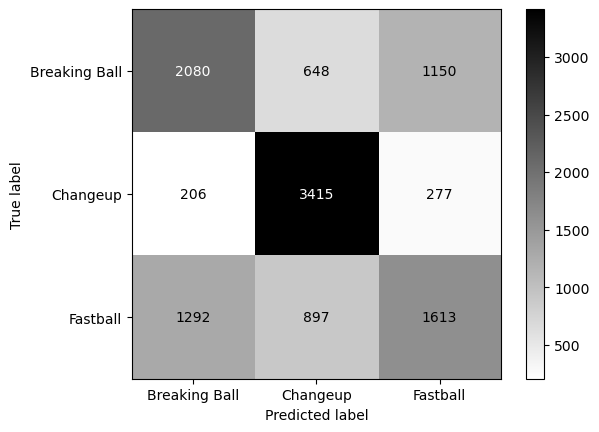

In [5]:
X = kclean[['balls', 'strikes', 'outs_when_up' ,'pitcher', 'at_bat_number','stand_L','stand_R']]
y = kclean[['pitch_class']]
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

f1score = f1_score(y_test, y_pred, average = 'micro')
print("Model F1 Score:", f1score)
conmax = confusion_matrix(y_test, y_pred, labels = model.classes_)
ConfusionMatrixDisplay(confusion_matrix=conmax, display_labels = model.classes_).plot(cmap='gray_r')
importances = model.feature_importances_
importances

Naive Bayes

In [6]:
X = kclean[['balls', 'strikes', 'outs_when_up','on_1b','on_2b','on_3b','pitcher','stand_L', 'stand_R']]
y = kclean[['pitch_class']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
nbmodel = MultinomialNB()
nbmodel.fit(X_train, y_train)
NBy_pred = nbmodel.predict(X_test)

nb_f1score = f1_score(y_test, NBy_pred, average = 'micro')
print("Model F1 Score:", f1score)
conmax = confusion_matrix(y_test, y_pred, labels = nbmodel.classes_)
ConfusionMatrixDisplay(confusion_matrix=conmax, display_labels = nbmodel.classes_).plot(cmap='gray_r')
print('please let me commit')

c:\Users\tober\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model F1 Score: 0.6139229573328727


ValueError: Found input variables with inconsistent numbers of samples: [7684, 11578]

Multinomial Logistic Regression


c:\Users\tober\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\tober\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23
[LightGBM] [Info] Number of data points in the train set: 30732, number of used features: 9
[LightGBM] [Info] Start training from score -0.810686
[LightGBM] [Info] Start training from score -2.950313
[LightGBM] [Info] Start training from score -0.686919
Model F1 Score: 0.6017699115044248


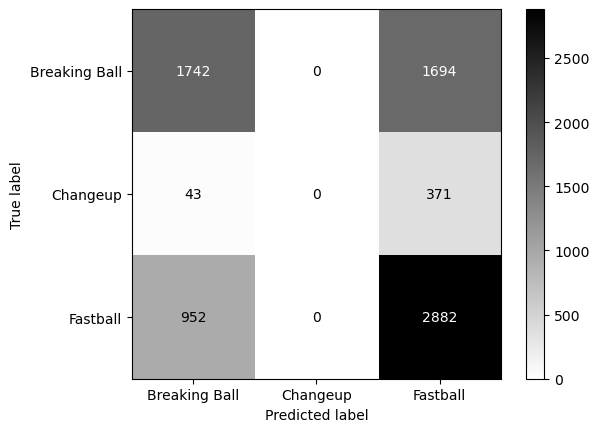

In [39]:
X = kclean[['balls', 'strikes', 'outs_when_up','on_1b','on_2b','on_3b','pitcher','stand_L','stand_R']]
y = kclean[['pitch_class']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#label_encoder = LabelEncoder()
#y_train_encoded = label_encoder.fit_transform(y_train)
#y_test_encoded = label_encoder.transform(y_test)

LRmodel = LGBMClassifier()
LRmodel.fit(X_train, y_train)

y_pred = LRmodel.predict(X_test)
#y_pred = label_encoder.inverse_transform(y_pred_encoded)
f1score = f1_score(y_test, y_pred, average = 'micro')
print("Model F1 Score:", f1score)
conmax = confusion_matrix(y_test, y_pred, labels = LRmodel.classes_)
ConfusionMatrixDisplay(confusion_matrix=conmax, display_labels = LRmodel.classes_).plot(cmap='gray_r')